In [1]:
import json
import requests
from bs4 import BeautifulSoup
import os
import re
import textract
import string
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import metrics
from sklearn.feature_selection import SelectPercentile, SelectFromModel
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
#in order to use SMOTE, you've got to import Pipeline from imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import dill as pickle
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

# Import Labeled Texts

In [2]:
def create_labeled_df(labeled_data_path):
    '''
    Create a pandas DataFrame with the labled attachment texts.
    
    Arguments:
        labeled_data_path (str): the directory for the labeled attachment text files.
        
    Returns:
        labeled_df (pandas DataFrame): a dataframe with a column for the file name, 
                                       the text, and the label (green, yellow or red).
    '''
    
    texts = []
    files = []
    labels = []
    for file in os.listdir(labeled_data_path):
        if file.startswith('.'):
            continue
        else:
            files.append(file)
            label = file.split('_')[0]
            labels.append(label)
            file_path = os.path.join(labeled_data_path,file)
            #use latin1 encoding to be generous with decoding
            with open(file_path, 'r', encoding='latin1') as f:
                text = f.read()
                texts.append(text)
    labeled_df = pd.DataFrame(data=[files,texts,labels]).transpose()
    labeled_df.columns = ['file','text','label']
    return labeled_df

In [3]:
labeled_df = create_labeled_df('labeled_fbo_docs')

In [4]:
labeled_df.head()

,file,text,label
0,GREEN_10-223-SOL-00051.txt,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",GREEN
1,GREEN_1055518.txt,\nStatement of Work -\n ...,GREEN
2,GREEN_1055521.txt,\n\nStatement of Work:\n\n1.0 BACKGROUND\nFD...,GREEN
3,GREEN_1057498.txt,\nAttachment A- High availability equipment (T...,GREEN
4,GREEN_105787.txt,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",GREEN


In [5]:
labeled_df['label'].value_counts()

RED       507
GREEN     271
YELLOW    215
Name: label, dtype: int64

In [6]:
#recode labels to numeric
labeled_df['target'] = labeled_df['label'].map({'GREEN':0,'YELLOW':1,'RED':1})

## Normalize text

In [7]:
def remove_punctuation(text):
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    s = regex.sub(' ', text)
    return s

def remove_formatting(text):
    output = text.replace('\t', ' ').replace('\n', ' ').replace('\r', ' ').replace('\x0b', ' ').replace('\x0c', ' ')
    return output

def transform_for_classifier(text):
    temp = remove_punctuation(text)
    final = remove_formatting(temp)
    return final

In [8]:
# normalize the comments, preparing for tf-idf
labeled_df['normalized text'] = labeled_df['text'].astype(str).apply(transform_for_classifier)

## Grid Search

In [9]:
# functions for plotting classification results
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print("="*80)
    print("Operating point = {:.3f}".format(t),end="\n\n")
    print("Confusion Matrix:")
    print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_green', 'pred_red'], 
                       index=['green', 'red']),end="\n\n")
    print("Classification Report:")
    print(metrics.classification_report(y_test, y_pred_adj, target_names=['green', 'red']))
    
    
    font = {'family' : 'normal',
            'weight' : 'medium',
            'size'   : 18}

    plt.rc('font', **font)
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold",fontdict=font)
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.0, 1.01]);
    plt.xlim([0.0, 1.01]);
    plt.xlabel('Recall',fontdict=font);
    plt.ylabel('Precision',fontdict=font);
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    font = {'family' : 'normal',
            'weight' : 'medium',
            'size'   : 18}

    plt.rc('font', **font)
    
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold",fontdict=font)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score",fontdict=font)
    plt.xlabel("Decision Threshold",fontdict=font)
    plt.legend(loc='best',fontsize=16)
    
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
    
def plot_fpr_recall_vs_threshold(y_test, y_scores):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]
    
    
    fpr, tpr, roc_thresh = metrics.roc_curve(y_test, y_scores)
    p, r, prc_thresh = metrics.precision_recall_curve(y_test, y_scores)
    
    font = {'family' : 'normal',
            'weight' : 'medium',
            'size'   : 18}

    plt.rc('font', **font)
   
    plt.figure(figsize=(8, 8))
    plt.title("False Positive and Recall Scores as a function of the decision threshold",fontdict=font)

    plt.plot(prc_thresh, r[:-1], "b--", label="Recall")
    plt.plot(roc_thresh, fpr, "g-", label="FPR")
    
    #plot vertical line where recall is highest (i.e. == 1)
    x_text = prc_thresh[0]
    plt.axvline(x=x_text)
    #plot horizontal line that will intersect where the vertical line hits the fpr line
    y_text = fpr[np.where(roc_thresh==find_nearest(roc_thresh, prc_thresh[0]))[0][0]]
    plt.axhline(y=y_text)
    x = round(x_text,2)
    y = round(y_text,2)
    plt.text(x_text,y_text,"({}, {})".format(x, y))
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best',fontsize=16)
    
def plot_prc(y_score, y_test):
    """
    Plot the precision-recall curve, labeled with average precision.
    """
    average_precision = metrics.average_precision_score(y_test, y_score)

    precision, recall, _ = metrics.precision_recall_curve(y_test, y_score)
    #plot it
    plt.figure(figsize=(8,8))
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall',fontsize=16)
    plt.ylabel('Precision',fontsize=16)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision),fontsize=20)

class log_uniform():        
    """
    Provides an instance of the log-uniform distribution with an .rvs() method. Meant to be used with 
    RandomizedSearchCV, particularly for params like alpha, C, gamma, etc. 
    
    Attributes:
        a (int or float): the exponent of the beginning of the range 
        b (int or float): the exponent of the end of range. 
        base (int or float): the base of the logarithm. 10 by default.
    """
    
    def __init__(self, a=-1, b=0, base=10):
        self.loc = a
        self.scale = b - a
        self.base = base

    def rvs(self, size=1, random_state=None):
        uniform = stats.uniform(loc=self.loc, scale=self.scale)
        return np.power(self.base, uniform.rvs(size=size, random_state=random_state))    
    
def randomized_grid_search(df, clf=SGDClassifier(), n_iter_search = 500, score='roc_auc',
                           pickle_best=True):
    """
    Given labeled training data (`df`) for a binary classification task, performs a 
    randomized grid search `n_iter_search` times using `clf` as the classifier the `score`
    as a scoring metric.
    
    Attributes:
        df (pandas DataFrame):  the training data. Currently, you must specify within the function
                                label and feature column names.
        clf (instance of an sklearn classifier):  SGDClassifier() by default
        n_iter_search:  number of parameter settings that are sampled. Trades off runtime vs quality 
                        of the solution.
        score (str):  the scorer used to evaluate the predictions on the test set. `roc_auc` by
                      default. Available options include:  accuracy, roc_auc, precision, fbeta, recall.
                      Note: for fbeta, beta is set to 1.5 to favor recall of the positive class.
    """
    scoring = {'accuracy': metrics.make_scorer(metrics.accuracy_score),
               'roc_auc': metrics.make_scorer(metrics.roc_auc_score),
               'precision': metrics.make_scorer(metrics.average_precision_score),
               'fbeta':metrics.make_scorer(metrics.fbeta_score,beta=1.5),
               'recall':metrics.make_scorer(metrics.recall_score)}
    clf_name = clf.__class__.__name__
    X = df['normalized text']
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y,
                                                        stratify=y,
                                                        test_size=0.2)
    pipe = Pipeline([
                     ('vectorizer',TfidfVectorizer(stop_words='english', strip_accents='ascii')),
                     ('select',SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3))),
                     ('clf', clf)])

    param_dist = {
                  "vectorizer__ngram_range":[(1,1), (1,2)],
                  "vectorizer__min_df":stats.randint(1,3),
                  "vectorizer__max_df":stats.uniform(.95,.3),
                  "vectorizer__sublinear_tf":[True, False],
                  "clf__alpha": log_uniform(-5,2),
                  "clf__penalty": ['l2','l1','elasticnet'],
                  "clf__loss": ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
                  }
    
    random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, 
                                       scoring=scoring, refit=score,
                                       n_iter=n_iter_search, cv=5,n_jobs=-1,verbose=1)
    random_search.fit(X_train, y_train)
    
    y_pred = random_search.predict(X_test)
    #get the col number of the positive class (i.e. red/yellow)
    positive_class_col = list(random_search.classes_).index(1)
    try:
        y_score = random_search.predict_proba(X_test)[:,positive_class_col]
    except AttributeError:
        y_score = random_search.decision_function(X_test)
    average_precision = metrics.average_precision_score(y_test, y_score)
    acc = metrics.accuracy_score(y_test,y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_pred)
    precisions, recalls, _ = metrics.precision_recall_curve(y_test, y_score)
    auc = metrics.auc(recalls, precisions)
    fbeta = metrics.fbeta_score(y_test,y_pred,beta=1.5)
    recall = metrics.recall_score(y_test,y_pred)

    print("\tRecall on test data:  {0:.2f}".format(recall))
    print("\tAccuracy on test data:  {0:.2f}".format(acc))
    print("\tROC-AUC on test data:  {0:.2f}".format(roc_auc))
    print("\tFbeta on test data:  {0:.2f}".format(fbeta))
    print("\tAverage Precision on test data:  {0:.2f}".format(average_precision))
    print("\tPrecision-Recall AUC on test data:  {0:.2f}".format(auc))
    print("-"*80)
    print("Classification Report:")
    class_names = ['green', 'red']
    print(metrics.classification_report(y_test, y_pred, target_names=class_names))
    print("-"*80)
    plot_prc(y_score, y_test)
    print("-"*80)
    fpr, tpr, auc_thresholds = metrics.roc_curve(y_test, y_score)
    print("AUC of ROC:  {0:.4f}".format(metrics.auc(fpr, tpr)))
    plot_roc_curve(fpr, tpr, 'ROC Curve')
    best_estimator = random_search.best_estimator_
    best_score = random_search.best_score_
    result_values = [y_pred, y_score, precisions, recall, average_precision,
                     acc, roc_auc, auc, fbeta, recalls, best_score, best_estimator, y_test]
    result_keys = ['y_pred', 'y_score', 'precisions', 'recall', 'average_precision','acc',
                   'roc_auc', 'auc', 'fbeta', 'recalls','best_score','best_estimator','y_test']
    results = {k:v for k,v in zip(result_keys,result_values)}
    
    if pickle_best:
        pickle_path = os.path.join(os.getcwd(),'best_clf_scott.pkl')
        with open(pickle_path, 'wb') as f: 
            pickle.dump(random_search.best_estimator_, f) 
    return results

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 188.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 430.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 758.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 970.9min finished


	Recall on test data:  0.84
	Accuracy on test data:  0.82
	ROC-AUC on test data:  0.80
	Fbeta on test data:  0.86
	Average Precision on test data:  0.97
	Precision-Recall AUC on test data:  0.97
--------------------------------------------------------------------------------
Classification Report:
             precision    recall  f1-score   support

      green       0.64      0.76      0.69        54
        red       0.90      0.84      0.87       145

avg / total       0.83      0.82      0.82       199

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
AUC of ROC:  0.9225


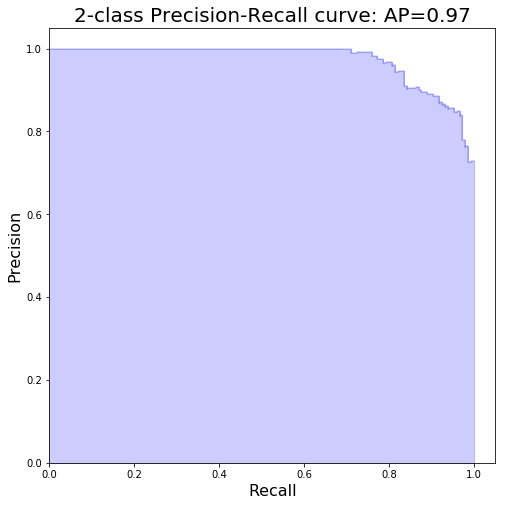

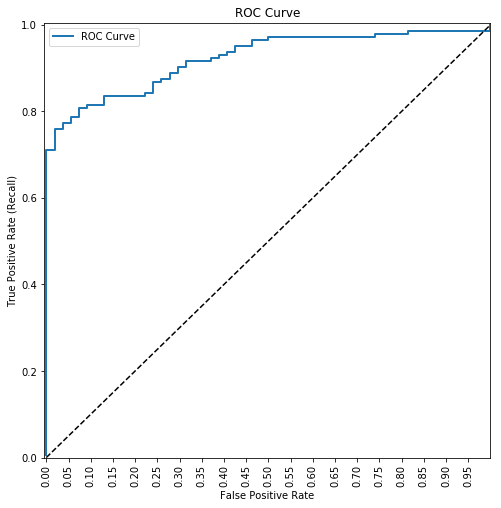

In [18]:
results = randomized_grid_search(labeled_df,
                                 clf = SGDClassifier(),
                                 n_iter_search = 200,
                                 score = 'accuracy',
                                 pickle_best = True)

## Benchmark against dummy classifiers
These dummy classifiers will make different sorts of educated guesses on whether or not a comment is spam or ham. Hopefully our trained classifer out-performs these guesses.

In [7]:
X = np.zeros(shape=labeled_df.shape)
y = labeled_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    stratify=y,
                                                    random_state=123)

for strategy in ['stratified','most_frequent','prior','uniform']:
    print("="*80)
    print(strategy)
    print("="*80)
    dummy = DummyClassifier(strategy=strategy)
    dummy.fit(X_train, y_train)
    y_pred = dummy.predict(X_test)
    #get the col number of the positive class (i.e. spam)
    positive_class_col = list(dummy.classes_).index(1)
    y_score = dummy.predict_proba(X_test)[:,positive_class_col]
    average_precision = metrics.average_precision_score(y_test, y_score)
    acc = metrics.accuracy_score(y_test,y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_pred)
    precisions, recalls, _ = metrics.precision_recall_curve(y_test, y_score)
    auc = metrics.auc(recalls, precisions)
    fbeta = metrics.fbeta_score(y_test,y_pred,beta=2)
    recall = metrics.recall_score(y_test,y_pred)
    print("\tRecall on test data:  {0:.2f}".format(recall))
    print("\tAccuracy on test data:  {0:.2f}".format(acc))
    print("\tROC-AUC on test data:  {0:.2f}".format(roc_auc))
    print("\tFbeta on test data:  {0:.2f}".format(fbeta))
    print("\tAverage Precision on test data:  {0:.2f}".format(average_precision))
    print("\tPrecision-Recall AUC on test data:  {0:.2f}".format(auc))

stratified
	Recall on test data:  0.77
	Accuracy on test data:  0.64
	ROC-AUC on test data:  0.53
	Fbeta on test data:  0.76
	Average Precision on test data:  0.72
	Precision-Recall AUC on test data:  0.82
most_frequent
	Recall on test data:  1.00
	Accuracy on test data:  0.73
	ROC-AUC on test data:  0.50
	Fbeta on test data:  0.93
	Average Precision on test data:  0.73
	Precision-Recall AUC on test data:  0.86
prior
	Recall on test data:  1.00
	Accuracy on test data:  0.73
	ROC-AUC on test data:  0.50
	Fbeta on test data:  0.93
	Average Precision on test data:  0.73
	Precision-Recall AUC on test data:  0.86
uniform
	Recall on test data:  0.38
	Accuracy on test data:  0.40
	ROC-AUC on test data:  0.41
	Fbeta on test data:  0.42
	Average Precision on test data:  0.73
	Precision-Recall AUC on test data:  0.86


The prior and most frequent strategies peform well because the classes are so imbalanced. We should recommend acquisition of more labeled data, particularly `green` samples.